In [1]:
import matplotlib.pyplot as plt
from spacepy import pycdf
import numpy as np
import matplotlib.dates as mdates
import math
import datetime as dt
from datetime import datetime, timedelta
from matplotlib.axis import Axis
from matplotlib.pyplot import cm
from itertools import compress

C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\franc\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
class rpw_ratio_lab:
    
    def __init__(self, date, start_event, end_event, filepath_hfr, filepath_tnr):
        self.date = date
        self.start_event = start_event
        self.end_event = end_event
        self.filepath_hfr = filepath_hfr
        self.filepath_tnr = filepath_tnr
    
    @staticmethod
    def array_dupes(a):
        u, c = np.unique(a, return_counts=True)
        dup = u[c > 1]
        return len(dup)
    @staticmethod
    def to_timestamp(array): # Converts datetime arrays into timestamp arrays
        timestamps = list(map(lambda x: datetime.timestamp(x), array))
        return timestamps
    @staticmethod
    def to_date(array): # Converts timestamp arrays into datetime arrays
        mydates = list(map(lambda x: datetime.fromtimestamp(x), array))
        return mydates
    @staticmethod
    def freq_chooser(a, m):
        choice = list(map(lambda x: len(x) == m, a))
        return choice
    @staticmethod
    def available_time(t, dt):
        return np.mod(t, dt)
    @staticmethod
    def join_sensors(x, y, n):
        x_non = np.where(x <= n)
        #y_non = np.where(y > n)
        x[x_non] = y[x_non]
        return x
    @staticmethod
    def stack_n_stretch(a):
        tile_a = np.tile(a, (32,1))
        stack_a = np.transpose(np.stack(tile_a, axis=0))
        stretch_a = np.concatenate(stack_a)
        return stretch_a
    @staticmethod
    def no_negs(a):
        b = np.where(a<=0)
        a[b] = 0*a[b]
        return a
    @staticmethod
    def join_tnr(x, y, n1, n2, n3):
        x_non = np.where((x != n1)&(x != n2)&(x != n3))
        x[x_non] = y[x_non]
        return x
    
    def header(self):
        head_txt = """
        Import the following modules:
        
        import matplotlib.pyplot as plt
        from spacepy import pycdf
        import numpy as np
        import matplotlib.dates as mdates
        import math
        import datetime as dt
        from datetime import datetime, timedelta
        from matplotlib.axis import Axis
        from matplotlib.pyplot import cm
        from itertools import compress
        """
        print(head_txt)
    
    def data_hfr(self):
        
        cdf_file = pycdf.CDF(self.filepath_hfr)
        
        freq_, epoch_, AGC_, sensor_ = cdf_file['FREQUENCY'][...], cdf_file['Epoch'][...], self.join_sensors(cdf_file['AGC1'][...], cdf_file['AGC2'][...], 0), self.join_sensors(cdf_file['SENSOR_CONFIG'][0:-1,0], cdf_file['SENSOR_CONFIG'][0:-1,1], 8)
        condition = np.where((sensor_==9))
        freq, epoch, AGC, sensor = freq_[condition], epoch_[condition], AGC_[condition], sensor_[condition]
        
        freq_num = self.array_dupes(freq)
        freq_list = freq[0:freq_num]
        freq_choice_ = list(map(lambda x: list(np.array(np.where(freq==x)[0])), freq_list))
        
        max_len = np.max(list(map(lambda x: len(x), freq_choice_)))
        freq_choice = list(compress(freq_choice_,self.freq_chooser(freq_choice_, max_len)))
        frequencies = list(compress(freq_list, self.freq_chooser(freq_choice_, max_len)))
        freq_num = len(frequencies)
        # For each frequency, apply same indexes to time and flux
        epoch_choice = epoch[freq_choice]
        AGC_choice = AGC[freq_choice]

        yyyy, mm, dd = self.date.split('-')
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        time_start = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_s), int(MM_s), int(SS_s))
        time_end = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_e), int(MM_e), int(SS_e))

        def time_inter(t_arr):
            start = np.abs(np.array(self.to_timestamp(t_arr))-datetime.timestamp(time_start)).argmin()
            end = np.abs(np.array(self.to_timestamp(t_arr))-datetime.timestamp(time_end)).argmin()
            return [start, end]

        middle_freq = math.ceil(len(frequencies)/2.)
        start = time_inter(epoch_choice[middle_freq])[0]
        end = time_inter(epoch_choice[middle_freq])[1]

        epoch_choice_plot = epoch_choice[:, start:end]
        AGC_choice_plot = AGC_choice[:, start:end]
        middle_freq = math.ceil(len(frequencies)/2.)
        
        def ten_min_cal(t, f):
            f_max = np.argmax(f[start:end])
            t_max = t[start:end]
            m = np.where(t == t_max[f_max])
            di = t[m[0]]-timedelta(minutes = 50)
            df = t[m[0]]-timedelta(minutes = 40)
            i = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(di[0])).argmin()
            j = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(df[0])).argmin()
            c = np.median(f[i:j])
            return c

        def ten_min_cal_plus(t, f):
            f_max = np.argmax(f[start:end])
            t_max = t[start:end]
            m = np.where(t == t_max[f_max])
            di = t[m[0]]+timedelta(minutes = 20)
            df = t[m[0]]+timedelta(minutes = 30)
            i = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(di[0])).argmin()
            j = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(df[0])).argmin()
            c = np.median(f[i:j])
            return c
        
        Spectro = []

        for i in list(range(0, freq_num)):
            order = np.argsort(self.to_timestamp(epoch_choice_plot[i]))
            if int(HH_s)<1:
                AGC_specter = np.interp(np.sort(self.to_timestamp(epoch_choice_plot[middle_freq])), self.to_timestamp(epoch_choice_plot[i]), AGC_choice_plot[i]) - ten_min_cal_plus(epoch_choice[i], AGC_choice[i])
                AGC_specter[AGC_specter <= 0] = ten_min_cal_plus(epoch_choice[i], AGC_choice[i])
            else:
                AGC_specter = np.interp(np.sort(self.to_timestamp(epoch_choice_plot[middle_freq])), self.to_timestamp(epoch_choice_plot[i]), AGC_choice_plot[i]) - ten_min_cal(epoch_choice[i], AGC_choice[i])
                AGC_specter[AGC_specter <= 0] = ten_min_cal(epoch_choice[i], AGC_choice[i])
            Spectro.append(list(AGC_specter))
        data_dict = {'time': self.to_date(np.sort(self.to_timestamp(epoch_choice_plot[middle_freq]))), 'frequencies': np.array(frequencies), 'l2_spectrum': Spectro}

        return data_dict
    
    def data_tnr(self):
        
        cdf_file = pycdf.CDF(self.filepath_tnr)
        
        freq_ , epoch_, AUTO_, sensor = np.concatenate(cdf_file['FREQUENCY'][...]), self.stack_n_stretch(cdf_file['Epoch'][...]), self.join_sensors(np.concatenate(self.no_negs(cdf_file['AUTO1'][...])), np.concatenate(self.no_negs(cdf_file['AUTO2'][...])), 0), self.stack_n_stretch(self.join_tnr(cdf_file['SENSOR_CONFIG'][...][:, 0], cdf_file['SENSOR_CONFIG'][...][:, 1], 4, 5, 6))                
        condit = np.where((sensor==4)&((freq_<100000)|(freq_>130000)))
        freq, epoch, AUTO = freq_[condit], epoch_[condit], AUTO_[condit]
        
        freq_num = self.array_dupes(freq)
        freq_list = freq[0:freq_num]
        freq_choice_ = list(map(lambda x: list(np.array(np.where(freq==x)[0])), freq_list))
        
        max_len = np.max(list(map(lambda x: len(x), freq_choice_)))
        freq_choice = list(compress(freq_choice_,self.freq_chooser(freq_choice_, max_len)))
        frequencies = list(compress(freq_list, self.freq_chooser(freq_choice_, max_len)))
        freq_num = len(frequencies)
        # For each frequency, apply same indexes to time and flux
        epoch_choice = epoch[freq_choice]
        AUTO_choice = AUTO[freq_choice]

        yyyy, mm, dd = self.date.split('-')
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        time_start = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_s), int(MM_s), int(SS_s))
        time_end = dt.datetime(int(yyyy), int(mm), int(dd), int(HH_e), int(MM_e), int(SS_e))

        def time_inter(t_arr):
            start = np.abs(np.array(self.to_timestamp(t_arr))-datetime.timestamp(time_start)).argmin()
            end = np.abs(np.array(self.to_timestamp(t_arr))-datetime.timestamp(time_end)).argmin()
            return [start, end]

        middle_freq = math.ceil(len(frequencies)/2.)
        start = time_inter(epoch_choice[middle_freq])[0]
        end = time_inter(epoch_choice[middle_freq])[1]

        epoch_choice_plot = epoch_choice[:, start:end]
        AUTO_choice_plot = AUTO_choice[:, start:end]
        middle_freq = math.ceil(len(frequencies)/2.)
        
        def ten_min_cal(t, f):
            f_max = np.argmax(f[start:end])
            t_max = t[start:end]
            m = np.where(t == t_max[f_max])
            di = t[m[0]]-timedelta(minutes = 50)
            df = t[m[0]]-timedelta(minutes = 40)
            i = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(di[0])).argmin()
            j = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(df[0])).argmin()
            c = np.median(f[i:j])
            return c

        def ten_min_cal_plus(t, f):
            f_max = np.argmax(f[start:end])
            t_max = t[start:end]
            m = np.where(t == t_max[f_max])
            di = t[m[0]]+timedelta(minutes = 20)
            df = t[m[0]]+timedelta(minutes = 30)
            i = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(di[0])).argmin()
            j = np.abs(np.array(self.to_timestamp(t))- datetime.timestamp(df[0])).argmin()
            c = np.median(f[i:j])
            return c
        
        Spectro = []

        for i in list(range(0, freq_num)):
            order = np.argsort(self.to_timestamp(epoch_choice_plot[i]))
            if int(HH_s)<1:
                AUTO_specter = np.interp(np.sort(self.to_timestamp(epoch_choice_plot[middle_freq])), self.to_timestamp(epoch_choice_plot[i]), AUTO_choice_plot[i]) - ten_min_cal_plus(epoch_choice[i], AUTO_choice[i])
                AUTO_specter[AUTO_specter <= 0] = ten_min_cal_plus(epoch_choice[i], AUTO_choice[i])
            else:
                AUTO_specter = np.interp(np.sort(self.to_timestamp(epoch_choice_plot[middle_freq])), self.to_timestamp(epoch_choice_plot[i]), AUTO_choice_plot[i]) - ten_min_cal(epoch_choice[i], AUTO_choice[i])
                AUTO_specter[AUTO_specter <= 0] = ten_min_cal(epoch_choice[i], AUTO_choice[i])
            Spectro.append(list(AUTO_specter))
        data_dict = {'time': self.to_date(np.sort(self.to_timestamp(epoch_choice_plot[middle_freq]))), 'frequencies': np.array(frequencies), 'l2_spectrum': Spectro}

        return data_dict
    
    def plot_ratio(self, fig_path):
        
        tnr_data = rpw_ratio_lab(self.date, self.start_event, self.end_event, self.filepath_hfr, self.filepath_tnr).data_tnr()     
        hfr_data = rpw_ratio_lab(self.date, self.start_event, self.end_event, self.filepath_hfr, self.filepath_tnr).data_hfr()
        tnr_975 = tnr_data['l2_spectrum'][-1]
        hfr_975 = np.interp(self.to_timestamp(tnr_data['time']), self.to_timestamp(hfr_data['time']), hfr_data['l2_spectrum'][6])  
        
        HH_s, MM_s, SS_s = self.start_event.split(':')
        HH_e, MM_e, SS_e = self.end_event.split(':')
        
        def FWHM(t, f):
            half = np.max(f)/2.
            i = np.where(f >= half)
            return [t[np.min(i)], t[np.max(i)]]
        
        def halfpeak_avg(a, b):
            peak_condition = np.where(b > np.max(b)/2)
            peak_ratio = a[peak_condition]
            return np.average(peak_ratio)
        
        def halfpeak_err(a, b):
            peak_condition = np.where(b > np.max(b)/2)
            peak_ratio = a[peak_condition]
            return np.std(peak_ratio)
        
        half_max = FWHM(tnr_data['time'], hfr_975)
        avg = str('%.2f' % halfpeak_avg(tnr_975/hfr_975, tnr_975))
        err = str('%.2f' % halfpeak_err(tnr_975/hfr_975, tnr_975))
        lbl = avg + '$\pm$' + err
        
        fig = plt.figure(figsize=(60,35))
        ax_grid = fig.add_gridspec(1, 1)
        ax_ = ax_grid[0].subgridspec(2, 1, hspace=0.005)
        ax = [fig.add_subplot(ax_[0, 0]), fig.add_subplot(ax_[1, 0])]
        myFmt = mdates.DateFormatter('%H:%M')
        ax[0].plot(tnr_data['time'], hfr_975, 'k', label='hfr 975 kHz', linewidth=4)
        ax[0].plot(tnr_data['time'], tnr_975, 'r', label='tnr 978 kHz', linewidth=4)
        ax[0].set_title(self.date + ' (yyyy-mm-dd)', fontsize=80)
        ax[0].axvspan(np.min([half_max[0]]), np.max([half_max[1]]), 0, 15, color='r', alpha=0.5, label='FWHM (hfr)')
        ax[0].set_ylim(np.min(hfr_975), 1.5*np.max(hfr_975))
        ax[0].set_yscale("log")
        ax[0].set_ylabel('V$_{12}$ Flux (V$^2$ Hz$^{-1}$)', fontsize=80)
        ax[0].set_xticks([])
        ax[1].plot(tnr_data['time'], tnr_975/hfr_975, 'k', linewidth=4)
        ax[1].axvspan(np.min([half_max[0]]), np.max([half_max[1]]), 0, 15, color='r', alpha=0.5)
        ax[1].hlines(1, tnr_data['time'][0], tnr_data['time'][-1], 'k', linestyle='--',linewidth=5, alpha=0.5)
        ax[1].hlines(halfpeak_avg(tnr_975/hfr_975, tnr_975), np.min([half_max[0]]), np.max([half_max[1]]), 'r', linestyle='--',linewidth=5, label=lbl)
        ax[1].set_xlabel('Time (HH:MM)', fontsize=80)
        ax[1].set_ylabel('V$_{12}^{tnr}$/V$_{12}^{hfr}$', fontsize=80)
        ax[1].set_ylim(0.1, 2)
        for a in ax:
            a.xaxis.set_major_formatter(myFmt)
            a.tick_params(axis='both', which='both', labelsize=60, length=25, width=4)
            a.legend(loc='upper right', fontsize = 60, frameon=False)
            a.yaxis.set_label_coords(-0.07, .5)
        plt.savefig(fig_path + 'hfr_tnr_ratio' + self.date + '_' + HH_s + '_' + HH_e + '.png', bbox_inches='tight')

In [3]:
#rpw_ratio_lab('2022-03-21', '05:15:00', '06:15:00', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220321_V06', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220321_V07').plot_ratio('hfr_tnr_ratio\\')     

In [9]:
date_list = ['2022-04-09', '2022-04-09', '2022-04-09', '2022-04-10', '2022-04-10', '2022-04-10', 
             '2022-04-13', '2022-04-13', '2022-04-13', '2022-04-15', '2022-04-15', '2022-04-16', 
             '2022-04-17', '2022-04-20']
start_list = ['03:35:00', '05:20:00', '11:30:00', '08:30:00', '00:00:00', '14:00:00', '03:00:00', 
              '07:55:00', '12:50:00', '19:40:00', '02:45:00', '18:45:00', '07:35:00', '03:30:00']
end_list = ['04:20:00', '06:00:00', '12:10:00', '09:05:00', '00:45:00', '14:50:00', '03:30:00', 
              '08:35:00', '13:30:00', '20:40:00', '03:30:00', '19:30:00', '08:30:00', '05:00:00']
file_list_hfr = ['RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220409_V03', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220409_V03', 
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220409_V03', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220410_V06',
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220410_V06', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220410_V06', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220413_V03', 
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220413_V03', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220413_V03', 
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220415_V02', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220415_V02',
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220416_V02', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220417_V06',
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-hfr-surv-cdag_20220420_V02']
file_list_tnr = ['RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220409_V04', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220409_V04', 
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220409_V04', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220410_V07',
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220410_V07', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220410_V07', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220413_V04', 
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220413_V04', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220413_V04', 
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220415_V03', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220415_V03',
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220416_V03', 'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220417_V07',
             'RPW_plotting\\ratio_vs_time_analysis\\solo_L2_rpw-tnr-surv-cdag_20220420_V03']

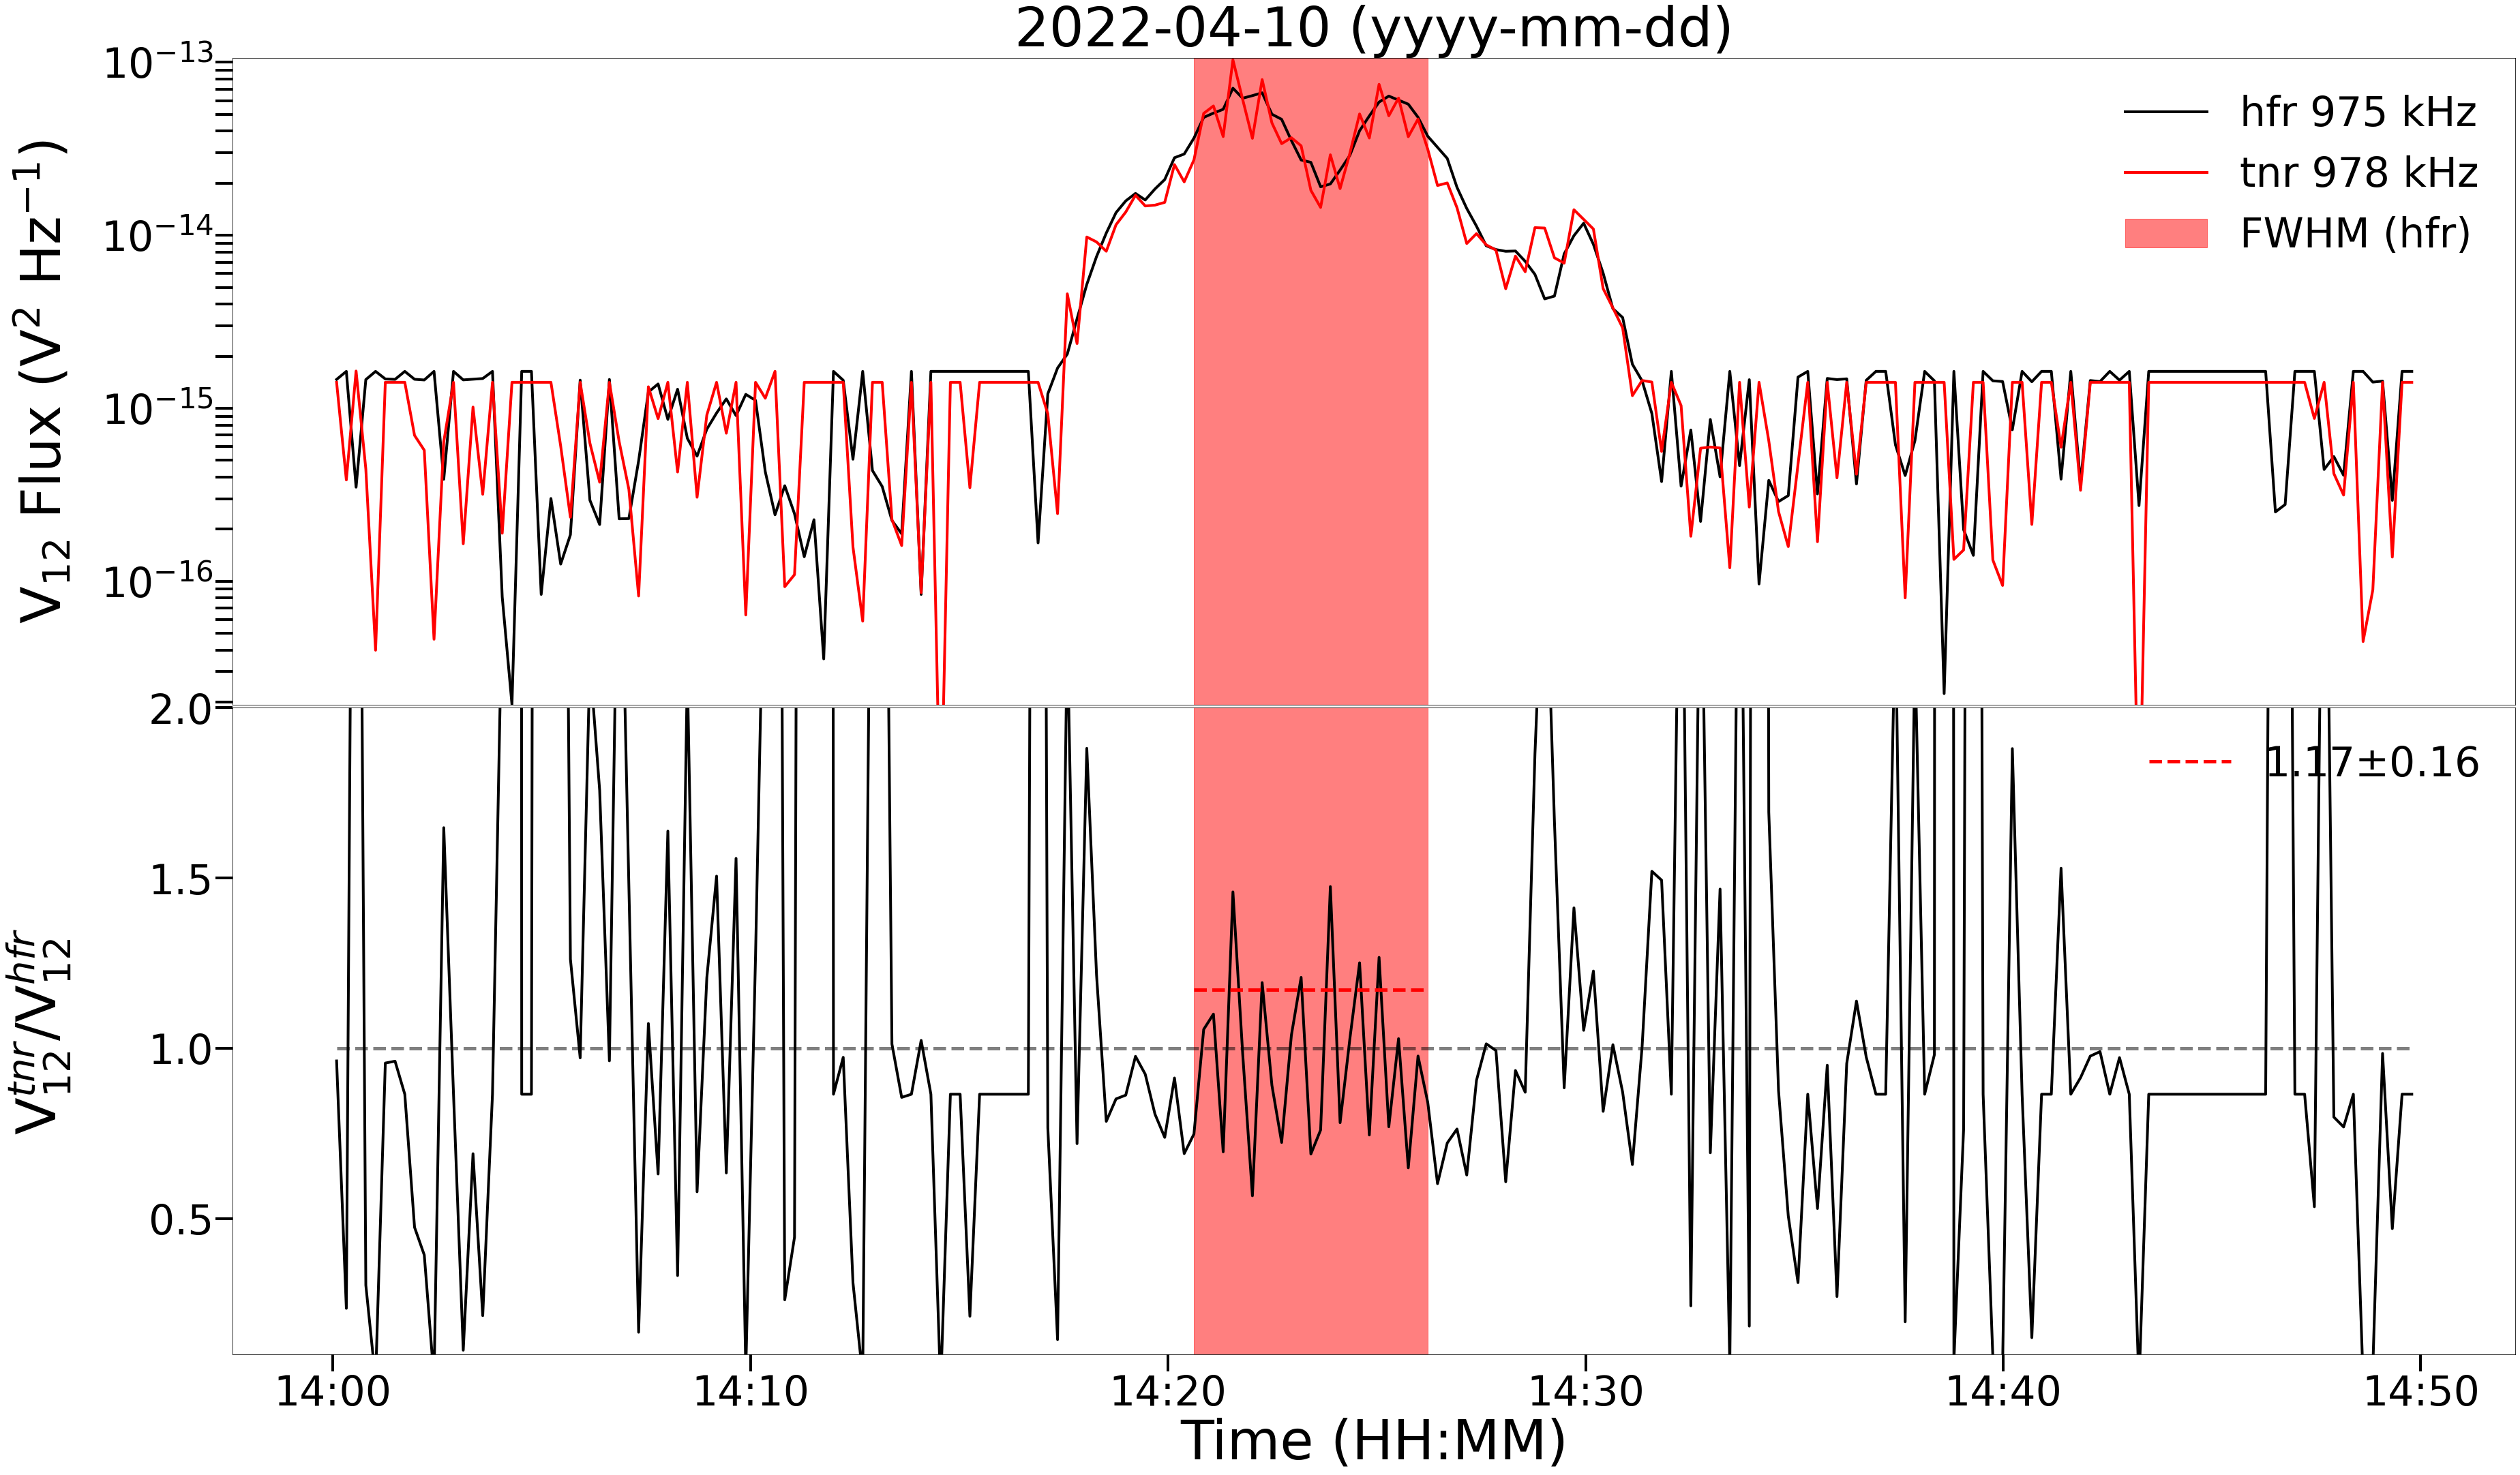

In [10]:
#for i in range(0, len(date_list)):
i=5
rpw_ratio_lab(date_list[i], start_list[i], end_list[i], file_list_hfr[i], file_list_tnr[i]).plot_ratio('hfr_tnr_ratio\\')
